# **Dynamic Random Network for an Urban Population under an Epidemic**



In [958]:
# import modules
import networkx as nx
import random
import time
import os
from collections import Counter
from matplotlib import pyplot as plt

# random seed for reproducibility
def get_random_seed():
  seed = int((time.time() * 1000) + os.getpid())
  random.seed(seed)
  return seed

# initialize parameters
n = 2500 # the population initializes with 2500 nodes
d = 2 # the average degree is 2, asumming connection to spouse and child
timesteps = 10000 # we simulate for 10000 timesteps

''' We assume that the population is divided into four compartments:
1. susceptible (S) for those who are not infected yet
2. infected (I) for those who have been infected
3. carrier (C) for those who carry the virus but are asymptomatic
4. immune (M) for those who are immune to the virus
Once an individual acquires the virus, they either become I or C.
Once an individual becomes I, they either die or heal.
Upon healing, they either become S or M.
'''
def node_color_set(G): # returns node colors for drawing
  node_colors = ['green' if G.nodes[node]['class_label'] == 'S' # susceptible individuals
      else 'red' if G.nodes[node]['class_label'] == 'I' # infected individuals
      else 'orange' if G.nodes[node]['class_label'] == 'M' # immune individuals
      else 'blue' for node in G.nodes()] # carrier individuals
  return node_colors

def birth_rate(num_nodes): # avg. birth rate is 17 per 1000 nodes
  return int((17 * num_nodes)/1000)

def death_rate(num_nodes): # avg. death rate is 11.2 per 1000 nodes
  return int((11.2 * num_nodes)/1000)

def emigration_rate(num_nodes): # on an avg. 33.33% of people without ties emigrate
  return int((num_nodes)/3)

def immigration_rate(num_nodes): # on an avg. 15 per 1000 nodes immigrate
  return int((15 * num_nodes)/1000)

carrier_imm_prob = 0.01 # probability of an immigrant being a carrier
break_prob = 0.05 # probability of breaking of an existing bond
bond_prob = 0.15 # probability of formation of bond with nodes at most two hops apart

def inf_death_rate(num_nodes): # avg. death rate for the infected is 25%
  return int((25*num_nodes)/100)

def inf_heal_rate(num_nodes): # avg. heal rate for the infected is 5%
  return int((5 * num_nodes)/100)

# Infection rates
S_to_C = 0.01
S_to_I = 0.29
H_to_M = 0.33

# initialize a BA network
G = nx.barabasi_albert_graph(n, d)
nx.set_node_attributes(G, 'S', 'class_label')
# network at t = 0
#print(G.number_of_nodes())
node_colors = node_color_set(G)
#nx.draw(G, nx.kamada_kawai_layout(G), node_size=5, node_color=node_colors, edge_color='black')

In [959]:
i = 0
count = n
OG_population = set(G.nodes())
my_seed = get_random_seed()

pop = [len(OG_population)]
no_tie = [len(list(nx.isolates(G)))]

susceptible_count = [len(OG_population)]
infected_count = [0]
carrier_count = [0]
immune_count = [0]

deaths_count = []
death_count = 0

for i in range(timesteps):
  population = G.nodes()

  # Natural deaths
  num_deaths = death_rate(len(population))
  death_count += num_deaths
  if len(population) <= num_deaths:
    break
  deaths = random.sample(population, num_deaths)
  OG_population = OG_population.difference(set(deaths))
  for death in deaths:
    G.remove_node(death)

  # Healing from infection
  infected_nodes = [node for node in population if G.nodes[node]['class_label'] == 'I']
  num_infected_heals = inf_heal_rate(len(infected_nodes))
  infected_heals = random.sample(infected_nodes, num_infected_heals)
  for heals in infected_heals:
    rand_prob = random.random()
    if rand_prob < H_to_M:
      G.nodes[heals]['class_label'] = 'M' # becoming immune
    else:
      G.nodes[heals]['class_label'] = 'S' # becoming susceptible again

  # Death due to infection
  infected_nodes = [node for node in population if G.nodes[node]['class_label'] == 'I']
  num_infected_deaths = inf_death_rate(len(infected_nodes))
  death_count += num_infected_deaths
  if len(population) <= num_infected_deaths:
    break
  infected_deaths = random.sample(infected_nodes, num_infected_deaths)
  for death in infected_deaths:
    OG_population = OG_population.difference(set([death]))
    G.remove_node(death)

  # Spread of infection
  for node in population:
    if G.nodes[node]['class_label'] in ['C', 'I']:  # carriers and infected spread the virus
      susceptible_neighbors = [neighbor for neighbor in G.neighbors(node) if G.nodes[neighbor]['class_label'] == 'S']
      for neighbor in susceptible_neighbors:
        rand_prob = random.random()
        if rand_prob < S_to_C:
          G.nodes[neighbor]['class_label'] = 'C' # becoming a carrier
        elif rand_prob < S_to_C + S_to_I:
          G.nodes[neighbor]['class_label'] = 'I' # becoming infected
        else:
          G.nodes[neighbor]['class_label'] = 'S' # remaining susceptible

  # Births
  if len(OG_population) < 2: # no surviving candidates to give birth
    births = 0
  else:
    births = birth_rate(len(population))
  for j in range(births):
    parents = random.sample(list(OG_population), 2) # associate a parent with each newborn
    G.add_edge(parents[0], parents[1]) # ensure the parents are connected
    G.add_node(n + j, class_label='S')
    for parent in parents:
      G.add_edge(n + j, parent)
  n += births

  # Emigration
  no_ties = list(nx.isolates(G)) # isolated people with no family tend to emigrate
  emigrations = emigration_rate(len(no_ties))
  emigrants = random.sample(no_ties, emigrations)
  OG_population = OG_population.difference(set(emigrants))
  for emigrant in emigrants:
    G.remove_node(emigrant)

  # Immigration
  if len(OG_population) < 3: # no surviving candidates to employ immigrants
    immigrations = 0
  else:
    immigrations = immigration_rate(len(population))
  for j in range(immigrations):
    if random.random() < carrier_imm_prob:
      node_class = 'C'
    else:
      node_class = 'S'
    G.add_node(n + j, class_label=node_class)
    contacts = random.sample(list(OG_population), 3) # associate a broker, a landlord and an employer with each immigrant
    for contact in contacts:
      G.add_edge(n + j, contact)
  n += immigrations

  # Existing Bond Breakings
  num_edges_to_remove = int(break_prob * G.number_of_edges())
  edges = list(G.edges())
  edges_to_remove = random.sample(edges, num_edges_to_remove)
  G.remove_edges_from(edges_to_remove)

  # New Bond Formations
  for node in G.nodes():
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
      second_degree_neighbors = list(G.neighbors(neighbor))
      potential_edges = [(neighbor, n) for n in second_degree_neighbors if n != node and not G.has_edge(neighbor, n)]
      for u, v in potential_edges:
        if random.random() < bond_prob:
          G.add_edge(u, v)

  i += 1
  if i % 50 == 0:
    OG_population = set(G.nodes()) # many of the newborn and immigrants settle in and become part of the community
    #node_classes = [G.nodes[node]['class_label'] for node in G.nodes()]
    #class_counts = Counter(node_classes)
    #print("Number of nodes in each class:")
    #for class_label, count in class_counts.items():
    #    print(f"{class_label}: {count}")
  # network at t = timestep
  #node_colors = node_color_set(G)
  #nx.draw(G, nx.kamada_kawai_layout(G), node_size=5, node_color=node_colors, edge_color='black')
  #plt.show()
  no_tie.append(len(list(nx.isolates(G))))
  pop.append(len(population))
  num_S = sum(1 for node in G.nodes if G.nodes[node]['class_label'] == 'S')
  num_I = sum(1 for node in G.nodes if G.nodes[node]['class_label'] == 'I')
  num_C = sum(1 for node in G.nodes if G.nodes[node]['class_label'] == 'C')
  num_M = sum(1 for node in G.nodes if G.nodes[node]['class_label'] == 'M')
  susceptible_count.append(num_S)
  infected_count.append(num_I)
  carrier_count.append(num_C)
  immune_count.append(num_M)
  deaths_count.append(death_count)

  # Premature stopping if infection becomes saturated
  if pop[-1] == pop [-2] == pop[-3]:
    if no_tie[-1] == no_tie[-2] == no_tie[-3]:
      infected_nodes = [node for node in population if G.nodes[node]['class_label'] == 'I']
      if len(infected_nodes) >= 1:
        break

timestep = my_list = list(range(i + 1))

<ipython-input-959-de259e701e2b>:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  deaths = random.sample(population, num_deaths)


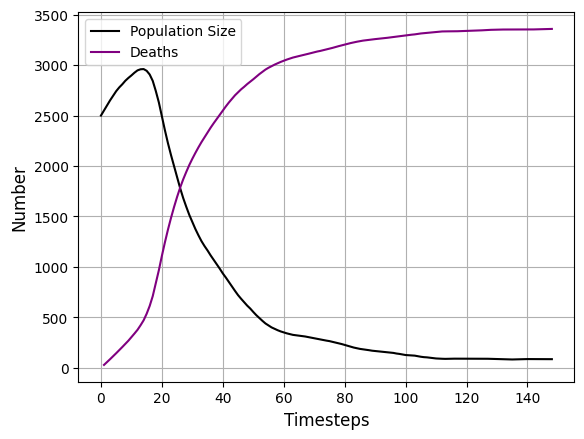

In [960]:
plt.plot(timestep, pop, linestyle='-', color='black', label="Population Size")
plt.plot(timestep[1:], deaths_count, linestyle='-', color='purple', label="Deaths")
#plt.plot(timestep, no_tie, linestyle='-', color='purple', label="Individuals with no ties")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

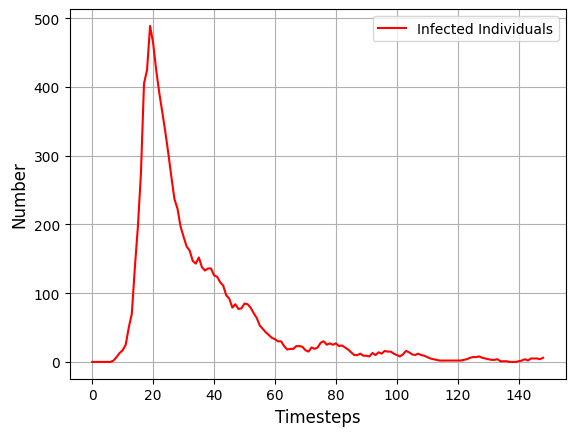

In [961]:
plt.plot(timestep, infected_count, linestyle='-', color='red', label="Infected Individuals")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# **Vaccination and Quarantine Campaign**

In [962]:
# import modules
import networkx as nx
import random
import time
import os
from collections import Counter
from matplotlib import pyplot as plt

# random seed for reproducibility
def get_random_seed():
  seed = int((time.time() * 1000) + os.getpid())
  random.seed(seed)
  return seed

# initialize parameters
n = 2500 # the population initializes with 2500 nodes
d = 2 # the average degree is 2, asumming connection to spouse and child
timesteps = 10000 # we simulate for 10000 timesteps

''' We assume that the population is divided into four compartments:
1. susceptible (S) for those who are not infected yet
2. infected (I) for those who have been infected
3. carrier (C) for those who carry the virus but are asymptomatic
4. immune (M) for those who are immune to the virus
Once an individual acquires the virus, they either become I or C.
Once an individual becomes I, they either die or heal.
Upon healing, they either become S or M.
'''
def node_color_set(G): # returns node colors for drawing
  node_colors = ['green' if G.nodes[node]['class_label'] == 'S' # susceptible individuals
      else 'red' if G.nodes[node]['class_label'] == 'I' # infected individuals
      else 'orange' if G.nodes[node]['class_label'] == 'M' # immune individuals
      else 'blue' for node in G.nodes()] # carrier individuals
  return node_colors

def birth_rate(num_nodes): # avg. birth rate is 17 per 1000 nodes
  return int((17 * num_nodes)/1000)

def death_rate(num_nodes): # avg. death rate is 11.2 per 1000 nodes
  return int((11.2 * num_nodes)/1000)

def emigration_rate(num_nodes): # on an avg. 33.33% of people without ties emigrate
  return int((num_nodes)/3)

def immigration_rate(num_nodes): # on an avg. 15 per 1000 nodes immigrate
  return int((15 * num_nodes)/1000)

carrier_imm_prob = 0.01 # probability of an immigrant being a carrier
break_prob = 0.05 # probability of breaking of an existing bond
bond_prob = 0.15 # probability of formation of bond with nodes at most two hops apart

def inf_death_rate(num_nodes): # avg. death rate for the infected is 25%
  return int((25*num_nodes)/100)

def inf_heal_rate(num_nodes): # avg. heal rate for the infected is 5%
  return int((5 * num_nodes)/100)

# Infection rates
S_to_C = 0.01
S_to_I = 0.29
H_to_M = 0.33

# initialize a BA network
G = nx.barabasi_albert_graph(n, d)
nx.set_node_attributes(G, 'S', 'class_label')
# network at t = 0
#print(G.number_of_nodes())
node_colors = node_color_set(G)
#nx.draw(G, nx.kamada_kawai_layout(G), node_size=5, node_color=node_colors, edge_color='black')

In [963]:
# copy H1 and H2 from G
H1 = G.copy()
H2 = G.copy()

In [964]:
i = 0
count = n
OG_population = set(G.nodes())
my_seed = get_random_seed()

pop = [len(OG_population)]
no_tie = [len(list(nx.isolates(G)))]

susceptible_count = [len(OG_population)]
infected_count = [0]
carrier_count = [0]
immune_count = [0]

deaths_count = []
death_count = 0

for i in range(timesteps):
  population = G.nodes()

  # Natural deaths
  num_deaths = death_rate(len(population))
  death_count += num_deaths
  if len(population) <= num_deaths:
    break
  deaths = random.sample(population, num_deaths)
  OG_population = OG_population.difference(set(deaths))
  for death in deaths:
    G.remove_node(death)

  # Healing from infection
  infected_nodes = [node for node in population if G.nodes[node]['class_label'] == 'I']
  num_infected_heals = inf_heal_rate(len(infected_nodes))
  infected_heals = random.sample(infected_nodes, num_infected_heals)
  for heals in infected_heals:
    rand_prob = random.random()
    if rand_prob < H_to_M:
      G.nodes[heals]['class_label'] = 'M' # becoming immune
    else:
      G.nodes[heals]['class_label'] = 'S' # becoming susceptible again

  # Death due to infection
  infected_nodes = [node for node in population if G.nodes[node]['class_label'] == 'I']
  num_infected_deaths = inf_death_rate(len(infected_nodes))
  death_count += num_infected_deaths
  if len(population) <= num_infected_deaths:
    break
  infected_deaths = random.sample(infected_nodes, num_infected_deaths)
  for death in infected_deaths:
    OG_population = OG_population.difference(set([death]))
    G.remove_node(death)

  # Spread of infection
  for node in population:
    if G.nodes[node]['class_label'] in ['C', 'I']:  # carriers and infected spread the virus
      susceptible_neighbors = [neighbor for neighbor in G.neighbors(node) if G.nodes[neighbor]['class_label'] == 'S']
      for neighbor in susceptible_neighbors:
        rand_prob = random.random()
        if rand_prob < S_to_C:
          G.nodes[neighbor]['class_label'] = 'C' # becoming a carrier
        elif rand_prob < S_to_C + S_to_I:
          G.nodes[neighbor]['class_label'] = 'I' # becoming infected
        else:
          G.nodes[neighbor]['class_label'] = 'S' # remaining susceptible

  # Births
  if len(OG_population) < 2: # no surviving candidates to give birth
    births = 0
  else:
    births = birth_rate(len(population))
  for j in range(births):
    parents = random.sample(list(OG_population), 2) # associate a parent with each newborn
    G.add_edge(parents[0], parents[1]) # ensure the parents are connected
    G.add_node(n + j, class_label='S')
    for parent in parents:
      G.add_edge(n + j, parent)
  n += births

  # Emigration
  no_ties = list(nx.isolates(G)) # isolated people with no family tend to emigrate
  emigrations = emigration_rate(len(no_ties))
  emigrants = random.sample(no_ties, emigrations)
  OG_population = OG_population.difference(set(emigrants))
  for emigrant in emigrants:
    G.remove_node(emigrant)

  # Immigration
  if len(OG_population) < 3: # no surviving candidates to employ immigrants
    immigrations = 0
  else:
    immigrations = immigration_rate(len(population))
  for j in range(immigrations):
    if random.random() < carrier_imm_prob:
      node_class = 'C'
    else:
      node_class = 'S'
    G.add_node(n + j, class_label=node_class)
    contacts = random.sample(list(OG_population), 3) # associate a broker, a landlord and an employer with each immigrant
    for contact in contacts:
      G.add_edge(n + j, contact)
  n += immigrations

  # Existing Bond Breakings
  num_edges_to_remove = int(break_prob * G.number_of_edges())
  edges = list(G.edges())
  edges_to_remove = random.sample(edges, num_edges_to_remove)
  G.remove_edges_from(edges_to_remove)

  # New Bond Formations
  for node in G.nodes():
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
      second_degree_neighbors = list(G.neighbors(neighbor))
      potential_edges = [(neighbor, n) for n in second_degree_neighbors if n != node and not G.has_edge(neighbor, n)]
      for u, v in potential_edges:
        if random.random() < bond_prob:
          G.add_edge(u, v)

  i += 1
  if i % 50 == 0:
    OG_population = set(G.nodes()) # many of the newborn and immigrants settle in and become part of the community
    #node_classes = [G.nodes[node]['class_label'] for node in G.nodes()]
    #class_counts = Counter(node_classes)
    #print("Number of nodes in each class:")
    #for class_label, count in class_counts.items():
    #    print(f"{class_label}: {count}")
  # network at t = timestep
  #node_colors = node_color_set(G)
  #nx.draw(G, nx.kamada_kawai_layout(G), node_size=5, node_color=node_colors, edge_color='black')
  #plt.show()
  no_tie.append(len(list(nx.isolates(G))))
  pop.append(len(population))
  num_S = sum(1 for node in G.nodes if G.nodes[node]['class_label'] == 'S')
  num_I = sum(1 for node in G.nodes if G.nodes[node]['class_label'] == 'I')
  num_C = sum(1 for node in G.nodes if G.nodes[node]['class_label'] == 'C')
  num_M = sum(1 for node in G.nodes if G.nodes[node]['class_label'] == 'M')
  susceptible_count.append(num_S)
  infected_count.append(num_I)
  carrier_count.append(num_C)
  immune_count.append(num_M)
  deaths_count.append(death_count)

  # Premature stopping if infection becomes saturated
  if pop[-1] == pop [-2] == pop[-3]:
    if no_tie[-1] == no_tie[-2] == no_tie[-3]:
      infected_nodes = [node for node in population if G.nodes[node]['class_label'] == 'I']
      if len(infected_nodes) >= 1:
        break

timestep = my_list = list(range(i + 1))

<ipython-input-964-de259e701e2b>:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  deaths = random.sample(population, num_deaths)


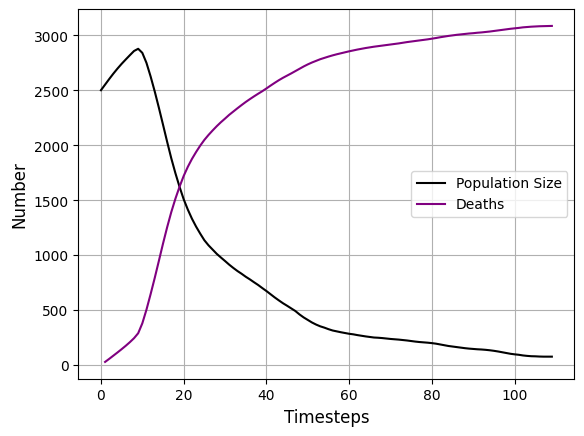

In [965]:
plt.plot(timestep, pop, linestyle='-', color='black', label="Population Size")
plt.plot(timestep[1:], deaths_count, linestyle='-', color='purple', label="Deaths")
#plt.plot(timestep, no_tie, linestyle='-', color='purple', label="Individuals with no ties")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

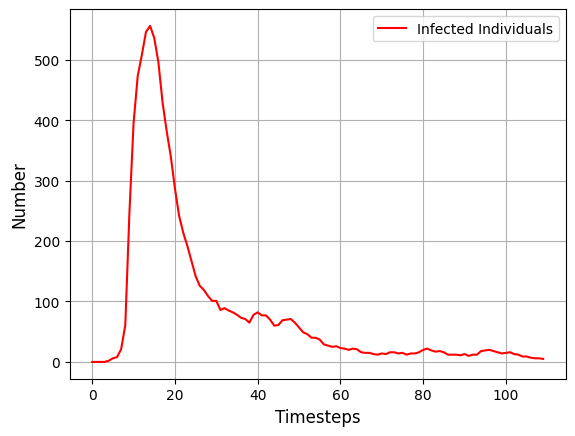

In [966]:
plt.plot(timestep, infected_count, linestyle='-', color='red', label="Infected Individuals")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [967]:
initiation_threshold = 0.9 # vaccination and quarantine campaigns initiated

## **Baseline Strategy**

In [968]:
vacc_efficiency = 0.95 # vaccination efficiency
vacc_count = 0.7 # standard for COVID models
quar_compliance = 0.75 # percentage of individuals complying with quarantine campaign
quar_ratio = 0.5 # standard for COVID models
flag = False

def isolate_nodes(G, node, edges_to_restore):
    """Isolate specified nodes by removing their edges and store the edges."""
    # Store the edges connected to the node
    edges_to_restore[node] = list(G.edges(node, data=True))

    # Remove the node's edges
    G.remove_edges_from(list(G.edges(node)))

    return edges_to_restore

def restore_node_edges(G, node, edges_to_restore):
    """Restore edges and node attributes for a specific node."""
    if node in edges_to_restore:
        # Get the original node attributes
        original_attributes = edges_to_restore[node][0][2]['attributes']
        # Add the node back with its original attributes
        G.add_node(node, **original_attributes)
        # Add the edges back
        G.add_edges_from(edges_to_restore[node])

In [969]:
i = 0
count = n
OG_population = set(H1.nodes())
vaccine_count = int(vacc_count * len(OG_population))
quar_count = int(quar_ratio * len(OG_population))
my_seed = get_random_seed()

pop = [len(OG_population)]
no_tie = [len(list(nx.isolates(H1)))]

susceptible_count = [len(OG_population)]
infected_count = [0]
carrier_count = [0]
immune_count = [0]

deaths_count = []
death_count = 0

quarantined = {}

for i in range(timesteps):
  population = H1.nodes()
  prev = len(population)

  # Natural deaths
  num_deaths = death_rate(len(population))
  death_count += num_deaths
  if len(population) <= num_deaths:
    break
  deaths = random.sample(population, num_deaths)
  OG_population = OG_population.difference(set(deaths))
  for death in deaths:
    H1.remove_node(death)
    if death in quarantined:
        del quarantined[death]

  # Healing from infection
  infected_nodes = [node for node in population if H1.nodes[node].get('class_label') in ['I']]
  num_infected_heals = inf_heal_rate(len(infected_nodes))
  infected_heals = random.sample(infected_nodes, num_infected_heals)
  for heals in infected_heals:
    rand_prob = random.random()
    if rand_prob < H_to_M:
      H1.nodes[heals]['class_label'] = 'M' # becoming immune
    else:
      H1.nodes[heals]['class_label'] = 'S' # becoming susceptible again

  # Death due to infection
  infected_nodes = [node for node in population if H1.nodes[node].get('class_label') in ['I']]
  num_infected_deaths = inf_death_rate(len(infected_nodes))
  death_count += num_infected_deaths
  if len(population) <= num_infected_deaths:
    break
  infected_deaths = random.sample(infected_nodes, num_infected_deaths)
  for death in infected_deaths:
    OG_population = OG_population.difference(set([death]))
    H1.remove_node(death)
    if death in quarantined:
        del quarantined[death]

  # Spread of infection
  for node in population:
    if H1.nodes[node].get('class_label') in ['C', 'I']:  # carriers and infected spread the virus
      susceptible_neighbors = [neighbor for neighbor in H1.neighbors(node) if H1.nodes[neighbor].get('class_label') in ['S']]
      for neighbor in susceptible_neighbors:
        rand_prob = random.random()
        if rand_prob < S_to_C:
          H1.nodes[neighbor]['class_label'] = 'C' # becoming a carrier
        elif rand_prob < S_to_C + S_to_I:
          H1.nodes[neighbor]['class_label'] = 'I' # becoming infected
        else:
          H1.nodes[neighbor]['class_label'] = 'S' # remaining susceptible

  # Births
  if len(OG_population) < 2: # no surviving candidates to give birth
    births = 0
  else:
    births = birth_rate(len(population))
  for j in range(births):
    parents = random.sample(list(OG_population), 2) # associate a parent with each newborn
    H1.add_edge(parents[0], parents[1]) # ensure the parents are connected
    H1.add_node(n + j, class_label='S')
    for parent in parents:
      H1.add_edge(n + j, parent)
  n += births

  # Emigration
  no_ties = list(nx.isolates(H1)) # isolated people with no family tend to emigrate
  emigrations = emigration_rate(len(no_ties))
  emigrants = random.sample(no_ties, emigrations)
  OG_population = OG_population.difference(set(emigrants))
  for emigrant in emigrants:
    H1.remove_node(emigrant)

  # Immigration
  if len(OG_population) < 3: # no surviving candidates to employ immigrants
    immigrations = 0
  else:
    immigrations = immigration_rate(len(population))
  for j in range(immigrations):
    if random.random() < carrier_imm_prob:
      node_class = 'C'
    else:
      node_class = 'S'
    H1.add_node(n + j, class_label=node_class)
    contacts = random.sample(list(OG_population), 3) # associate a broker, a landlord and an employer with each immigrant
    for contact in contacts:
      H1.add_edge(n + j, contact)
  n += immigrations

  # Existing Bond Breakings
  num_edges_to_remove = int(break_prob * H1.number_of_edges())
  edges = list(H1.edges())
  edges_to_remove = random.sample(edges, num_edges_to_remove)
  H1.remove_edges_from(edges_to_remove)

  # New Bond Formations
  for node in H1.nodes():
    neighbors = list(H1.neighbors(node))
    for neighbor in neighbors:
      second_degree_neighbors = list(H1.neighbors(neighbor))
      potential_edges = [(neighbor, n) for n in second_degree_neighbors if n != node and not H1.has_edge(neighbor, n)]
      for u, v in potential_edges:
        if random.random() < bond_prob:
          H1.add_edge(u, v)

  infected = [node for node in H1.nodes() if H1.nodes[node].get('class_label') in ['I']]
  if len(infected)/len(population) > initiation_threshold:
    flag = True

  if flag:
    # Vaccination
    vacc_candidates = [node for node in H1.nodes() if H1.nodes[node].get('class_label') in ['S', 'C']]
    num_vaccs = int(vaccine_count/50) # since restocking occurs every 50 timesteps
    if num_vaccs > len(vacc_candidates):
      num_vaccs = len(vacc_candidates)
    if len(vacc_candidates) < num_vaccs:
      num_vaccs = len(vacc_candidates)
    if num_vaccs < 0:
      num_vaccs = 0
    vacc_batch = random.sample(vacc_candidates, num_vaccs)
    for vacc in vacc_batch:
      if random.random() < vacc_efficiency:
        if H1.nodes[vacc]['class_label'] == 'S':
          H1.nodes[vacc]['class_label'] = 'M'
      vacc_count -= 1

    # Quarantine
    quar_candidates = set([node for node in H1.nodes() if H1.nodes[node].get('class_label') in ['I']]) - set(quarantined)
    num_quars = int(quar_count/50) # since survey undertaken every 50 timesteps
    if num_quars > len(quar_candidates):
      num_quars = len(quar_candidates)
    quar_batch = random.sample(quar_candidates, num_quars)
    for quar in quar_batch:
      if random.random() < quar_compliance:
        isolate_nodes(H1, quar, quarantined)
      quar_count -= 1

    # Quarantine End
    restored = []
    for node, edges in quarantined.items():
      if node in H1.nodes:
          if H1.nodes[node].get('class_label') not in ['I']:
            # Restore the node's edges
            H1.add_edges_from(edges)
            restored.append(node)
    # Remove node from quarantined dictionary
    for node in restored:
      del quarantined[node]

  i += 1
  if i % 50 == 0:
    OG_population = set(H1.nodes()) # many of the newborn and immigrants settle in and become part of the community
    vaccine_count = int(vacc_count * len(OG_population)) # vaccine restocking
    quar_count = int(quar_ratio * len(OG_population)) # quarantine survey
  no_tie.append(len(list(nx.isolates(H1))))
  pop.append(len(population))
  num_S = sum(1 for node in H1.nodes if H1.nodes[node].get('class_label') == 'S')
  num_I = sum(1 for node in H1.nodes if H1.nodes[node].get('class_label') == 'I')
  num_C = sum(1 for node in H1.nodes if H1.nodes[node].get('class_label') == 'C')
  num_M = sum(1 for node in H1.nodes if H1.nodes[node].get('class_label') == 'M')
  susceptible_count.append(num_S)
  infected_count.append(num_I)
  carrier_count.append(num_C)
  immune_count.append(num_M)
  deaths_count.append(death_count)

  # Premature stopping if infection becomes saturated
  if pop[-1] == pop [-2] == pop[-3]:
    if no_tie[-1] == no_tie[-2] == no_tie[-3]:
      infected_nodes = [node for node in population if H1.nodes[node]['class_label'] == 'I']
      if len(infected_nodes) >= 1:
        break

  # Premature stopping if infection is under control
  if flag:
    if prev < len(population):
      break

timestep = my_list = list(range(i + 1))

<ipython-input-969-8a202c69bd23>:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  deaths = random.sample(population, num_deaths)


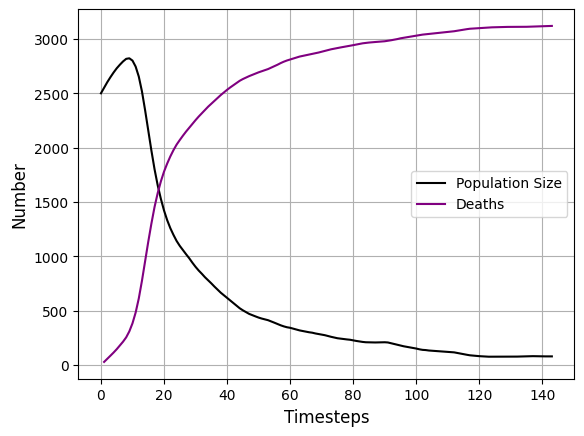

In [970]:
plt.plot(timestep, pop, linestyle='-', color='black', label="Population Size")
plt.plot(timestep[1:], deaths_count, linestyle='-', color='purple', label="Deaths")
#plt.plot(timestep, no_tie, linestyle='-', color='purple', label="Individuals with no ties")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

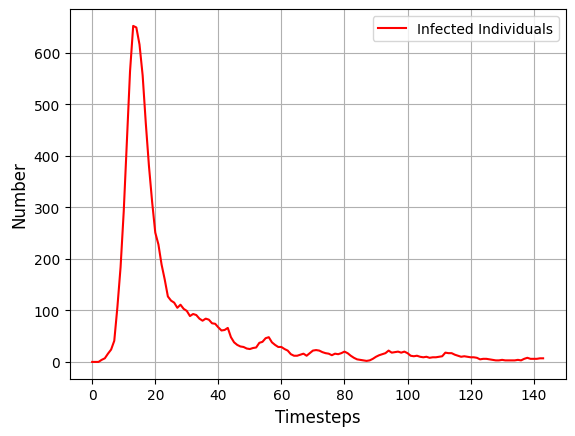

In [971]:
plt.plot(timestep, infected_count, linestyle='-', color='red', label="Infected Individuals")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## **Centrality-Based Strategy**

In [972]:
vacc_efficiency = 0.95 # vaccination efficiency
vacc_count = 0.7 # standard for COVID models
quar_compliance = 0.75 # percentage of individuals complying with quarantine campaign
quar_ratio = 0.5 # standard for COVID models
flag = False

def isolate_nodes(G, node, edges_to_restore):
    """Isolate specified nodes by removing their edges and store the edges."""
    # Store the edges connected to the node
    edges_to_restore[node] = list(G.edges(node, data=True))

    # Remove the node's edges
    G.remove_edges_from(list(G.edges(node)))

    return edges_to_restore

def restore_node_edges(G, node, edges_to_restore):
    """Restore edges and node attributes for a specific node."""
    if node in edges_to_restore:
        # Get the original node attributes
        original_attributes = edges_to_restore[node][0][2]['attributes']
        # Add the node back with its original attributes
        G.add_node(node, **original_attributes)
        # Add the edges back
        G.add_edges_from(edges_to_restore[node])

In [973]:
i = 0
count = n
OG_population = set(H2.nodes())
vaccine_count = int(vacc_count * len(OG_population))
quar_count = int(quar_ratio * len(OG_population))
my_seed = get_random_seed()

pop = [len(OG_population)]
no_tie = [len(list(nx.isolates(H2)))]

susceptible_count = [len(OG_population)]
infected_count = [0]
carrier_count = [0]
immune_count = [0]

deaths_count = []
death_count = 0

quarantined = {}

for i in range(timesteps):
  population = H2.nodes()
  prev = len(population)

  # Natural deaths
  num_deaths = death_rate(len(population))
  death_count += num_deaths
  if len(population) <= num_deaths:
    break
  deaths = random.sample(population, num_deaths)
  OG_population = OG_population.difference(set(deaths))
  for death in deaths:
    H2.remove_node(death)
    if death in quarantined:
        del quarantined[death]

  # Healing from infection
  infected_nodes = [node for node in population if H2.nodes[node].get('class_label') in ['I']]
  num_infected_heals = inf_heal_rate(len(infected_nodes))
  infected_heals = random.sample(infected_nodes, num_infected_heals)
  for heals in infected_heals:
    rand_prob = random.random()
    if rand_prob < H_to_M:
      H2.nodes[heals]['class_label'] = 'M' # becoming immune
    else:
      H2.nodes[heals]['class_label'] = 'S' # becoming susceptible again

  # Death due to infection
  infected_nodes = [node for node in population if H2.nodes[node].get('class_label') in ['I']]
  num_infected_deaths = inf_death_rate(len(infected_nodes))
  death_count += num_infected_deaths
  if len(population) <= num_infected_deaths:
    break
  infected_deaths = random.sample(infected_nodes, num_infected_deaths)
  for death in infected_deaths:
    OG_population = OG_population.difference(set([death]))
    H2.remove_node(death)
    if death in quarantined:
        del quarantined[death]

  # Spread of infection
  for node in population:
    if H2.nodes[node].get('class_label') in ['C', 'I']:  # carriers and infected spread the virus
      susceptible_neighbors = [neighbor for neighbor in H2.neighbors(node) if H2.nodes[neighbor].get('class_label') in ['S']]
      for neighbor in susceptible_neighbors:
        rand_prob = random.random()
        if rand_prob < S_to_C:
          H2.nodes[neighbor]['class_label'] = 'C' # becoming a carrier
        elif rand_prob < S_to_C + S_to_I:
          H2.nodes[neighbor]['class_label'] = 'I' # becoming infected
        else:
          H2.nodes[neighbor]['class_label'] = 'S' # remaining susceptible

  # Births
  if len(OG_population) < 2: # no surviving candidates to give birth
    births = 0
  else:
    births = birth_rate(len(population))
  for j in range(births):
    parents = random.sample(list(OG_population), 2) # associate a parent with each newborn
    H2.add_edge(parents[0], parents[1]) # ensure the parents are connected
    H2.add_node(n + j, class_label='S')
    for parent in parents:
      H2.add_edge(n + j, parent)
  n += births

  # Emigration
  no_ties = list(nx.isolates(H2)) # isolated people with no family tend to emigrate
  emigrations = emigration_rate(len(no_ties))
  emigrants = random.sample(no_ties, emigrations)
  OG_population = OG_population.difference(set(emigrants))
  for emigrant in emigrants:
    H2.remove_node(emigrant)

  # Immigration
  if len(OG_population) < 3: # no surviving candidates to employ immigrants
    immigrations = 0
  else:
    immigrations = immigration_rate(len(population))
  for j in range(immigrations):
    if random.random() < carrier_imm_prob:
      node_class = 'C'
    else:
      node_class = 'S'
    H2.add_node(n + j, class_label=node_class)
    contacts = random.sample(list(OG_population), 3) # associate a broker, a landlord and an employer with each immigrant
    for contact in contacts:
      H2.add_edge(n + j, contact)
  n += immigrations

  # Existing Bond Breakings
  num_edges_to_remove = int(break_prob * H2.number_of_edges())
  edges = list(H2.edges())
  edges_to_remove = random.sample(edges, num_edges_to_remove)
  H2.remove_edges_from(edges_to_remove)

  # New Bond Formations
  for node in H2.nodes():
    neighbors = list(H2.neighbors(node))
    for neighbor in neighbors:
      second_degree_neighbors = list(H2.neighbors(neighbor))
      potential_edges = [(neighbor, n) for n in second_degree_neighbors if n != node and not H2.has_edge(neighbor, n)]
      for u, v in potential_edges:
        if random.random() < bond_prob:
          H2.add_edge(u, v)

  infected = [node for node in H2.nodes() if H2.nodes[node].get('class_label') in ['I']]
  if len(infected)/len(population) > initiation_threshold:
    flag = True

  if flag:
    # Vaccination
    centrality_scores = nx.eigenvector_centrality(H2, max_iter=1000)
    sorted_nodes = sorted(centrality_scores.items(), key=lambda item: item[1], reverse=True)
    sorted_nodes = [node for node, score in sorted_nodes]
    vacc_candidates = [node for node in H2.nodes() if H2.nodes[node].get('class_label') in ['S', 'C']]
    sorted_vacc_candidates = [node for node in sorted_nodes if node in vacc_candidates]
    num_vaccs = int(vaccine_count/50) # since restocking occurs every 50 timesteps
    vacc_batch = sorted_vacc_candidates[:num_vaccs]  # Select top nodes
    for vacc in vacc_batch:
      if random.random() < vacc_efficiency:
        if H2.nodes[vacc]['class_label'] == 'S':
          H2.nodes[vacc]['class_label'] = 'M'
      vacc_count -= 1

    # Quarantine
    centrality_scores = nx.closeness_centrality(H2)
    sorted_nodes = sorted(centrality_scores.items(), key=lambda item: item[1], reverse=True)
    sorted_nodes = [node for node, score in sorted_nodes]
    quar_candidates = set([node for node in H2.nodes() if H2.nodes[node].get('class_label') in ['I']]) - set(quarantined)
    sorted_quar_candidates = [node for node in sorted_nodes if node in vacc_candidates]
    num_quars = int(quar_count/50) # since survey undertaken every 50 timesteps
    if num_quars > len(quar_candidates):
      num_quars = len(quar_candidates)
    quar_batch = sorted_quar_candidates[:num_quars]  # Select top nodes
    for quar in quar_batch:
      if random.random() < quar_compliance:
        isolate_nodes(H2, quar, quarantined)
      quar_count -= 1

    # Quarantine End
    restored = []
    for node, edges in quarantined.items():
      if node in H2.nodes:
          if H2.nodes[node].get('class_label') not in ['I']:
            # Restore the node's edges
            H2.add_edges_from(edges)
            restored.append(node)
    # Remove node from quarantined dictionary
    for node in restored:
      del quarantined[node]

  i += 1
  if i % 50 == 0:
    OG_population = set(H2.nodes()) # many of the newborn and immigrants settle in and become part of the community
    vaccine_count = int(vacc_count * len(OG_population)) # vaccine restocking
    quar_count = int(quar_ratio * len(OG_population)) # quarantine survey
  no_tie.append(len(list(nx.isolates(H2))))
  pop.append(len(population))
  num_S = sum(1 for node in H2.nodes if H2.nodes[node].get('class_label') == 'S')
  num_I = sum(1 for node in H2.nodes if H2.nodes[node].get('class_label') == 'I')
  num_C = sum(1 for node in H2.nodes if H2.nodes[node].get('class_label') == 'C')
  num_M = sum(1 for node in H2.nodes if H2.nodes[node].get('class_label') == 'M')
  susceptible_count.append(num_S)
  infected_count.append(num_I)
  carrier_count.append(num_C)
  immune_count.append(num_M)
  deaths_count.append(death_count)

  # Premature stopping if infection becomes saturated
  if pop[-1] == pop [-2] == pop[-3]:
    if no_tie[-1] == no_tie[-2] == no_tie[-3]:
      infected_nodes = [node for node in population if H2.nodes[node]['class_label'] == 'I']
      if len(infected_nodes) >= 1:
        break

  # Premature stopping if infection is under control
  if flag:
    if prev < len(population):
      break

timestep = my_list = list(range(i + 1))

<ipython-input-973-7bcb8b8a0d93>:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  deaths = random.sample(population, num_deaths)


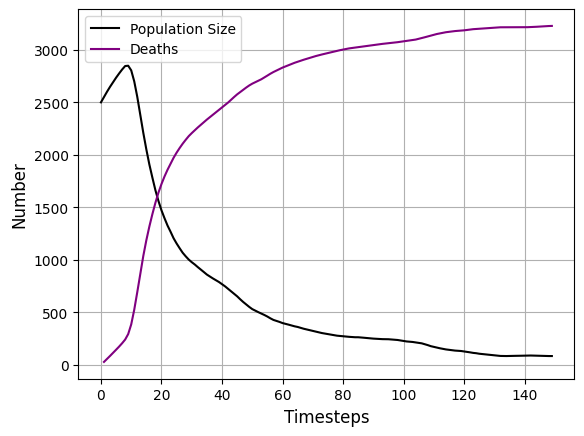

In [974]:
plt.plot(timestep, pop, linestyle='-', color='black', label="Population Size")
plt.plot(timestep[1:], deaths_count, linestyle='-', color='purple', label="Deaths")
#plt.plot(timestep, no_tie, linestyle='-', color='purple', label="Individuals with no ties")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

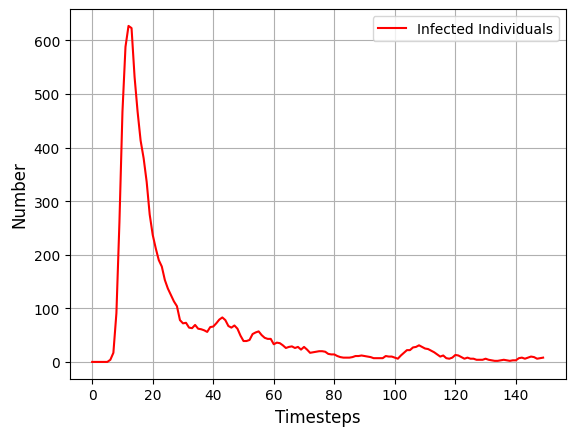

In [975]:
plt.plot(timestep, infected_count, linestyle='-', color='red', label="Infected Individuals")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# **Results**

In [976]:
print(G.number_of_nodes())
node_classes = [G.nodes[node]['class_label'] for node in G.nodes()]
class_counts = Counter(node_classes)
print("Number of nodes in each class:")
for class_label, count in class_counts.items():
  print(f"{class_label}: {count}")
print()
print(H1.number_of_nodes())
node_classes = [H1.nodes[node].get('class_label') for node in H1.nodes()]
class_counts = Counter(node_classes)
print("Number of nodes in each class:")
for class_label, count in class_counts.items():
  print(f"{class_label}: {count}")
print()
print(H2.number_of_nodes())
node_classes = [H2.nodes[node].get('class_label') for node in H2.nodes()]
class_counts = Counter(node_classes)
print("Number of nodes in each class:")
for class_label, count in class_counts.items():
  print(f"{class_label}: {count}")

76
Number of nodes in each class:
M: 15
C: 5
I: 5
S: 51

79
Number of nodes in each class:
M: 12
S: 59
C: 1
I: 7

84
Number of nodes in each class:
M: 9
S: 60
I: 8
C: 7


# **Mixed Strategy**

In [1]:
# import modules
import networkx as nx
import random
import time
import os
from collections import Counter
from matplotlib import pyplot as plt

# random seed for reproducibility
def get_random_seed():
  seed = int((time.time() * 1000) + os.getpid())
  random.seed(seed)
  return seed

# initialize parameters
n = 2500 # the population initializes with 2500 nodes
d = 2 # the average degree is 2, asumming connection to spouse and child
timesteps = 10000 # we simulate for 10000 timesteps

''' We assume that the population is divided into four compartments:
1. susceptible (S) for those who are not infected yet
2. infected (I) for those who have been infected
3. carrier (C) for those who carry the virus but are asymptomatic
4. immune (M) for those who are immune to the virus
Once an individual acquires the virus, they either become I or C.
Once an individual becomes I, they either die or heal.
Upon healing, they either become S or M.
'''
def birth_rate(num_nodes): # avg. birth rate is 17 per 1000 nodes
  return int((17 * num_nodes)/1000)

def death_rate(num_nodes): # avg. death rate is 11.2 per 1000 nodes
  return int((11.2 * num_nodes)/1000)

def emigration_rate(num_nodes): # on an avg. 33.33% of people without ties emigrate
  return int((num_nodes)/3)

def immigration_rate(num_nodes): # on an avg. 15 per 1000 nodes immigrate
  return int((15 * num_nodes)/1000)

carrier_imm_prob = 0.01 # probability of an immigrant being a carrier
break_prob = 0.05 # probability of breaking of an existing bond
bond_prob = 0.15 # probability of formation of bond with nodes at most two hops apart

def inf_death_rate(num_nodes): # avg. death rate for the infected is 25%
  return int((25*num_nodes)/100)

def inf_heal_rate(num_nodes): # avg. heal rate for the infected is 5%
  return int((5 * num_nodes)/100)

# Infection rates
S_to_C = 0.01
S_to_I = 0.29
H_to_M = 0.33

In [2]:
# initialize a BA network
H = nx.barabasi_albert_graph(n, d)
nx.set_node_attributes(H, 'S', 'class_label')

initiation_threshold = 0.1 # vaccination and quarantine campaigns initiated
vacc_efficiency = 0.95 # vaccination efficiency
vacc_count = 0.7 # standard for COVID models
quar_compliance = 0.75 # percentage of individuals complying with quarantine campaign
quar_ratio = 0.5 # standard for COVID models
flag = False

def isolate_nodes(G, node, edges_to_restore):
    """Isolate specified nodes by removing their edges and store the edges."""
    # Store the edges connected to the node
    edges_to_restore[node] = list(G.edges(node, data=True))

    # Remove the node's edges
    G.remove_edges_from(list(G.edges(node)))

    return edges_to_restore

def restore_node_edges(G, node, edges_to_restore):
    """Restore edges and node attributes for a specific node."""
    if node in edges_to_restore:
        # Get the original node attributes
        original_attributes = edges_to_restore[node][0][2]['attributes']
        # Add the node back with its original attributes
        G.add_node(node, **original_attributes)
        # Add the edges back
        G.add_edges_from(edges_to_restore[node])

In [3]:
i = 0
count = n
OG_population = set(H.nodes())
vaccine_count = int(vacc_count * len(OG_population))
quar_count = int(quar_ratio * len(OG_population))
my_seed = get_random_seed()

pop = [len(OG_population)]
no_tie = [len(list(nx.isolates(H)))]

susceptible_count = [len(OG_population)]
infected_count = [0]
carrier_count = [0]
immune_count = [0]

deaths_count = []
death_count = 0

quarantined = {}

for i in range(timesteps):
  population = H.nodes()
  prev = len(population)

  # Natural deaths
  num_deaths = death_rate(len(population))
  death_count += num_deaths
  if len(population) <= num_deaths:
    break
  deaths = random.sample(population, num_deaths)
  OG_population = OG_population.difference(set(deaths))
  for death in deaths:
    H.remove_node(death)
    if death in quarantined:
        del quarantined[death]

  # Healing from infection
  infected_nodes = [node for node in population if H.nodes[node].get('class_label') in ['I']]
  num_infected_heals = inf_heal_rate(len(infected_nodes))
  infected_heals = random.sample(infected_nodes, num_infected_heals)
  for heals in infected_heals:
    rand_prob = random.random()
    if rand_prob < H_to_M:
      H.nodes[heals]['class_label'] = 'M' # becoming immune
    else:
      H.nodes[heals]['class_label'] = 'S' # becoming susceptible again

  # Death due to infection
  infected_nodes = [node for node in population if H.nodes[node].get('class_label') in ['I']]
  num_infected_deaths = inf_death_rate(len(infected_nodes))
  death_count += num_infected_deaths
  if len(population) <= num_infected_deaths:
    break
  infected_deaths = random.sample(infected_nodes, num_infected_deaths)
  for death in infected_deaths:
    OG_population = OG_population.difference(set([death]))
    H.remove_node(death)
    if death in quarantined:
        del quarantined[death]

  # Spread of infection
  for node in population:
    if H.nodes[node].get('class_label') in ['C', 'I']:  # carriers and infected spread the virus
      susceptible_neighbors = [neighbor for neighbor in H.neighbors(node) if H.nodes[neighbor].get('class_label') in ['S']]
      for neighbor in susceptible_neighbors:
        rand_prob = random.random()
        if rand_prob < S_to_C:
          H.nodes[neighbor]['class_label'] = 'C' # becoming a carrier
        elif rand_prob < S_to_C + S_to_I:
          H.nodes[neighbor]['class_label'] = 'I' # becoming infected
        else:
          H.nodes[neighbor]['class_label'] = 'S' # remaining susceptible

  # Births
  if len(OG_population) < 2: # no surviving candidates to give birth
    births = 0
  else:
    births = birth_rate(len(population))
  for j in range(births):
    parents = random.sample(list(OG_population), 2) # associate a parent with each newborn
    H.add_edge(parents[0], parents[1]) # ensure the parents are connected
    H.add_node(n + j, class_label='S')
    for parent in parents:
      H.add_edge(n + j, parent)
  n += births

  # Emigration
  no_ties = list(nx.isolates(H)) # isolated people with no family tend to emigrate
  emigrations = emigration_rate(len(no_ties))
  emigrants = random.sample(no_ties, emigrations)
  OG_population = OG_population.difference(set(emigrants))
  for emigrant in emigrants:
    H.remove_node(emigrant)

  # Immigration
  if len(OG_population) < 3: # no surviving candidates to employ immigrants
    immigrations = 0
  else:
    immigrations = immigration_rate(len(population))
  for j in range(immigrations):
    if random.random() < carrier_imm_prob:
      node_class = 'C'
    else:
      node_class = 'S'
    H.add_node(n + j, class_label=node_class)
    contacts = random.sample(list(OG_population), 3) # associate a broker, a landlord and an employer with each immigrant
    for contact in contacts:
      H.add_edge(n + j, contact)
  n += immigrations

  # Existing Bond Breakings
  num_edges_to_remove = int(break_prob * H.number_of_edges())
  edges = list(H.edges())
  edges_to_remove = random.sample(edges, num_edges_to_remove)
  H.remove_edges_from(edges_to_remove)

  # New Bond Formations
  for node in H.nodes():
    neighbors = list(H.neighbors(node))
    for neighbor in neighbors:
      second_degree_neighbors = list(H.neighbors(neighbor))
      potential_edges = [(neighbor, n) for n in second_degree_neighbors if n != node and not H.has_edge(neighbor, n)]
      for u, v in potential_edges:
        if random.random() < bond_prob:
          H.add_edge(u, v)

  infected = [node for node in H.nodes() if H.nodes[node].get('class_label') in ['I']]
  if len(infected)/len(population) > initiation_threshold:
    flag = True

  if flag:
    # Vaccination
    centrality_scores = nx.eigenvector_centrality(H, max_iter=1000)
    sorted_nodes = sorted(centrality_scores.items(), key=lambda item: item[1], reverse=True)
    sorted_nodes = [node for node, score in sorted_nodes]
    vacc_candidates = [node for node in H.nodes() if H.nodes[node].get('class_label') in ['S', 'C']]
    sorted_vacc_candidates = [node for node in sorted_nodes if node in vacc_candidates]
    num_vaccs = int(vaccine_count/50) # since restocking occurs every 50 timesteps
    vacc_batch = sorted_vacc_candidates[:num_vaccs]  # Select top nodes
    for vacc in vacc_batch:
      if random.random() < vacc_efficiency:
        if H.nodes[vacc]['class_label'] == 'S':
          H.nodes[vacc]['class_label'] = 'M'
      vacc_count -= 1

    # Quarantine
    quar_candidates = set([node for node in H.nodes() if H.nodes[node].get('class_label') in ['I']]) - set(quarantined)
    num_quars = int(quar_count/50) # since survey undertaken every 50 timesteps
    if num_quars > len(quar_candidates):
      num_quars = len(quar_candidates)
    quar_batch = random.sample(quar_candidates, num_quars)
    for quar in quar_batch:
      if random.random() < quar_compliance:
        isolate_nodes(H, quar, quarantined)
      quar_count -= 1

    # Quarantine End
    restored = []
    for node, edges in quarantined.items():
      if node in H.nodes:
          if H.nodes[node].get('class_label') not in ['I']:
            # Restore the node's edges
            H.add_edges_from(edges)
            restored.append(node)
    # Remove node from quarantined dictionary
    for node in restored:
      del quarantined[node]

  i += 1
  if i % 50 == 0:
    OG_population = set(H.nodes()) # many of the newborn and immigrants settle in and become part of the community
    vaccine_count = int(vacc_count * len(OG_population)) # vaccine restocking
    quar_count = int(quar_ratio * len(OG_population)) # quarantine survey
  no_tie.append(len(list(nx.isolates(H))))
  pop.append(len(population))
  num_S = sum(1 for node in H.nodes if H.nodes[node].get('class_label') == 'S')
  num_I = sum(1 for node in H.nodes if H.nodes[node].get('class_label') == 'I')
  num_C = sum(1 for node in H.nodes if H.nodes[node].get('class_label') == 'C')
  num_M = sum(1 for node in H.nodes if H.nodes[node].get('class_label') == 'M')
  susceptible_count.append(num_S)
  infected_count.append(num_I)
  carrier_count.append(num_C)
  immune_count.append(num_M)
  deaths_count.append(death_count)

  # Premature stopping if infection becomes saturated
  if pop[-1] == pop [-2] == pop[-3]:
    if no_tie[-1] == no_tie[-2] == no_tie[-3]:
      infected_nodes = [node for node in population if H.nodes[node]['class_label'] == 'I']
      if len(infected_nodes) >= 1:
        break

  # Premature stopping if infection is under control
  if flag:
    if prev < len(population):
      break

timestep = my_list = list(range(i + 1))

<ipython-input-3-6d5bef8eba66>:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  deaths = random.sample(population, num_deaths)
<ipython-input-3-6d5bef8eba66>:151: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  quar_batch = random.sample(quar_candidates, num_quars)


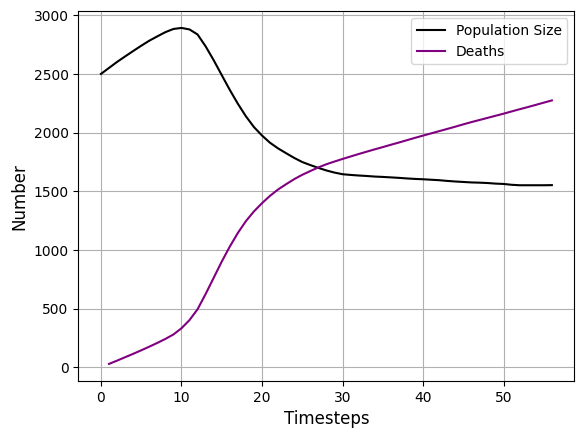

In [4]:
plt.plot(timestep, pop, linestyle='-', color='black', label="Population Size")
plt.plot(timestep[1:], deaths_count, linestyle='-', color='purple', label="Deaths")
#plt.plot(timestep, no_tie, linestyle='-', color='purple', label="Individuals with no ties")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

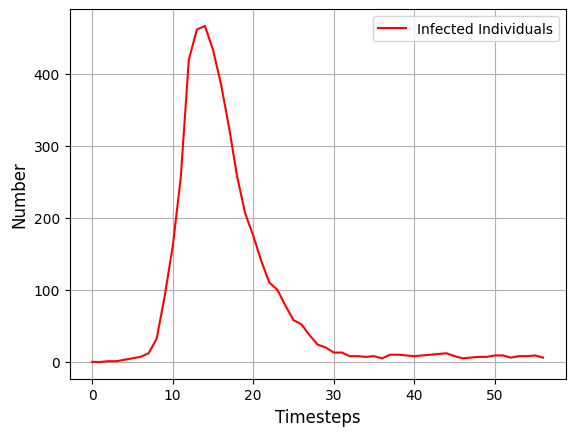

In [5]:
plt.plot(timestep, infected_count, linestyle='-', color='red', label="Infected Individuals")

# Adding labels and title
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()